<a href="https://colab.research.google.com/github/appliedcode/mthree-c422/blob/mthree-c422-Likhitha/ETL_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3177494880.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['Date'] = pd.to_datetime(df_long['Date'])


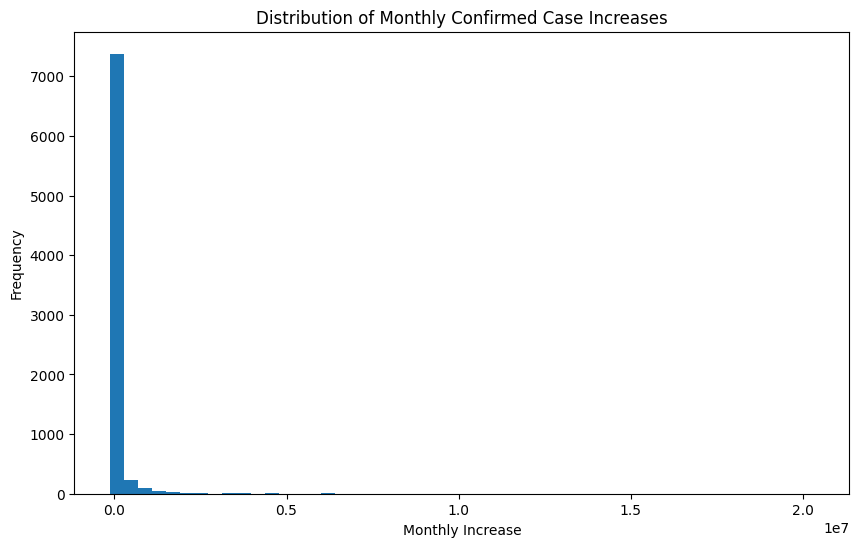

Top 5 Countries by Confirmed Cases in 2021-04
  Country  Confirmed
0      US   32468055
1   India   19164969
2  Brazil   14675104
3  France    5677829
4  Turkey    4820591

Monthly Growth Rates:
   Country    Month   GrowthRate
0   Brazil  2020-01     0.000000
1   Brazil  2020-02     0.000000
2   Brazil  2020-03  2857.500000
3   Brazil  2020-04    14.250481
4   Brazil  2020-05     4.919885
..     ...      ...          ...
73   India  2022-11     0.000431
74   India  2022-12     0.000135
75   India  2023-01     0.000095
76   India  2023-02     0.000083
77   India  2023-03     0.000065

[78 rows x 3 columns]

Countries with Zero Reported Cases in 2020-03
                  Country
0              Antarctica
1                 Comoros
2                Kiribati
3            Korea, North
4                 Lesotho
5                  Malawi
6        Marshall Islands
7              Micronesia
8                   Nauru
9                   Palau
10                  Samoa
11  Sao Tome and Principe
1

In [1]:
# --- Step 1: Import Required Libraries ---
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# --- Step 2: Extract ---

# Load the CSV file from JHU GitHub repository
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df_raw = pd.read_csv(url)

# --- Step 3: Transform ---

# Drop latitude and longitude
df = df_raw.drop(columns=["Lat", "Long"])

# Melt to long format
df_long = df.melt(id_vars=["Province/State", "Country/Region"], var_name="Date", value_name="Confirmed")

# Rename columns
df_long.rename(columns={"Country/Region": "Country", "Province/State": "Province"}, inplace=True)

# Convert Date to datetime
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Handle missing values
df_long['Confirmed'] = df_long['Confirmed'].fillna(0)

# Aggregate confirmed cases by country and date
df_country_daily = df_long.groupby(["Country", "Date"]).sum().reset_index()

# Add Month column
df_country_daily["Month"] = df_country_daily["Date"].dt.to_period("M").astype(str)

# Monthly confirmed cases per country
df_country_monthly = df_country_daily.groupby(["Country", "Month"])["Confirmed"].max().reset_index()

# Sort
df_country_monthly.sort_values(by=["Country", "Month"], inplace=True)

# Calculate monthly increase
df_country_monthly["MonthlyIncrease"] = df_country_monthly.groupby("Country")["Confirmed"].diff().fillna(0)

# Calculate growth rate
df_country_monthly["GrowthRate"] = (
    df_country_monthly["MonthlyIncrease"] / df_country_monthly["Confirmed"].shift(1).replace(0, np.nan)
).fillna(0)

# --- Optional: Histogram for Monthly Increase Distribution ---
plt.figure(figsize=(10, 6))
df_country_monthly["MonthlyIncrease"].hist(bins=50)
plt.title("Distribution of Monthly Confirmed Case Increases")
plt.xlabel("Monthly Increase")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

# --- Step 4: Load into SQLite ---

# Connect to SQLite (stored in memory or disk)
conn = sqlite3.connect("covid_data.db")

# Write dataframe to table
df_country_monthly.to_sql("covid_monthly", conn, if_exists="replace", index=False)

# --- Step 5: SQL Queries ---

# Query 1: Top 5 countries by confirmed cases in a selected month
selected_month = "2021-04"
query1 = f"""
SELECT Country, Confirmed
FROM covid_monthly
WHERE Month = '{selected_month}'
ORDER BY Confirmed DESC
LIMIT 5
"""
top5_countries = pd.read_sql_query(query1, conn)
print("Top 5 Countries by Confirmed Cases in", selected_month)
print(top5_countries)

# Query 2: Monthly growth rate comparison for selected countries
selected_countries = ("India", "United States", "Brazil")
query2 = f"""
SELECT Country, Month, GrowthRate
FROM covid_monthly
WHERE Country IN {selected_countries}
ORDER BY Country, Month
"""
growth_rates = pd.read_sql_query(query2, conn)
print("\nMonthly Growth Rates:")
print(growth_rates)

# Query 3: Countries with zero reported cases in a selected month
zero_case_month = "2020-03"
query3 = f"""
SELECT Country
FROM covid_monthly
WHERE Month = '{zero_case_month}' AND Confirmed = 0
"""
zero_cases = pd.read_sql_query(query3, conn)
print(f"\nCountries with Zero Reported Cases in {zero_case_month}")
print(zero_cases)

# Close connection
conn.close()
